# Human Body Measurement Predictor: A Computer Vision Project

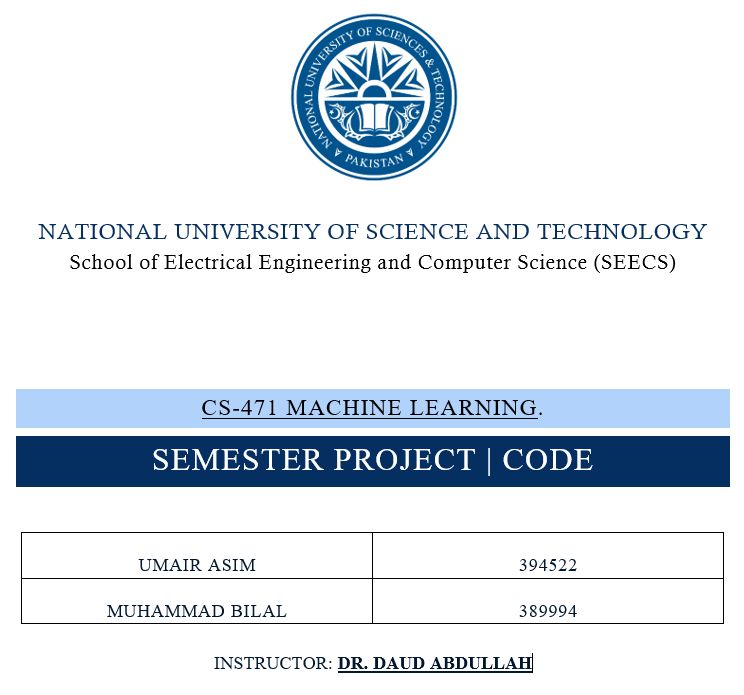

# Project Description

The accurate measurement of human body dimensions using computer vision poses several challenges and complexities:
-	Variability in Human Anatomy: Humans exhibit diverse body shapes, sizes, and proportions, requiring robust algorithms capable of handling this variability.
-	Image Quality and Noise: Digital images may contain noise, artifacts, or variations in lighting and pose, which can affect the accuracy of feature extraction.
-	Keypoint Detection and Localization: Identifying key body landmarks (e.g., joints, contours) accurately from images is crucial for precise measurement extraction.
-	3D Reconstruction: Transforming 2D images into accurate 3D representations of the human body involves complex geometric and computational challenges.
-	Model Generalization: Ensuring that the developed system can generalize well to unseen individuals and scenarios beyond the training dataset.

Addressing these challenges requires a combination of advanced computer vision techniques, machine learning algorithms, and careful data preprocessing to achieve reliable and consistent measurement extraction from human body images. By overcoming these complexities, the project aims to provide a robust and scalable solution for automated anthropometric analysis, benefiting a wide range of industries and applications.

This python notebook provides the complete code for our Human Body Measurement Predictor.


# Importing necessary libraries

In [67]:
#Data loading and representation
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import csv
from scipy.stats import norm

#Image loading and representation
from glob import glob
from PIL import Image
import cv2
import os

#Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score


# Exploratory Data Analysis

### Feature Input

In [54]:
train_images = glob('train_images/*.png')
train_images[2]
img_mpl = plt.imread(train_images[2])
img_cv2 = cv2.imread(train_images[2])
img_mpl

array([[[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       ...,

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0.

In [55]:
img_mpl.shape

(960, 720, 4)

In [56]:
img_mpl / 255 

array([[[0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        ...,
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157]],

       [[0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        ...,
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157]],

       [[0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        ...,
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.      

## Description of input

- The input are png images of shape 960x720 pixels
- Each png image represents a black silhoutte of the front pose of a human
- The png images are NOT gray-scaled.
- The images are loaded and flattened into array form, and then normalized

## Visualizing the input

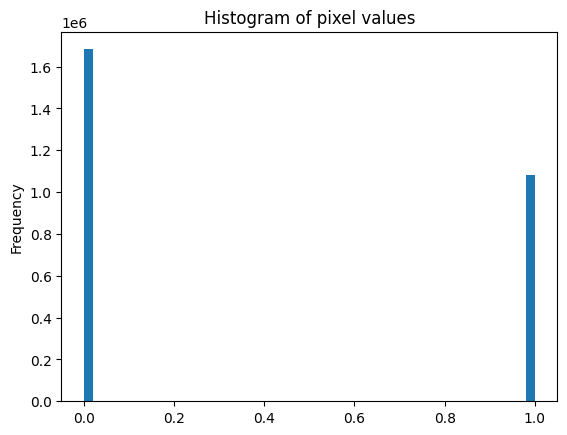

In [57]:
pd.Series(img_mpl.flatten()).plot(kind='hist', bins=50, title='Histogram of pixel values')
          
plt.show()

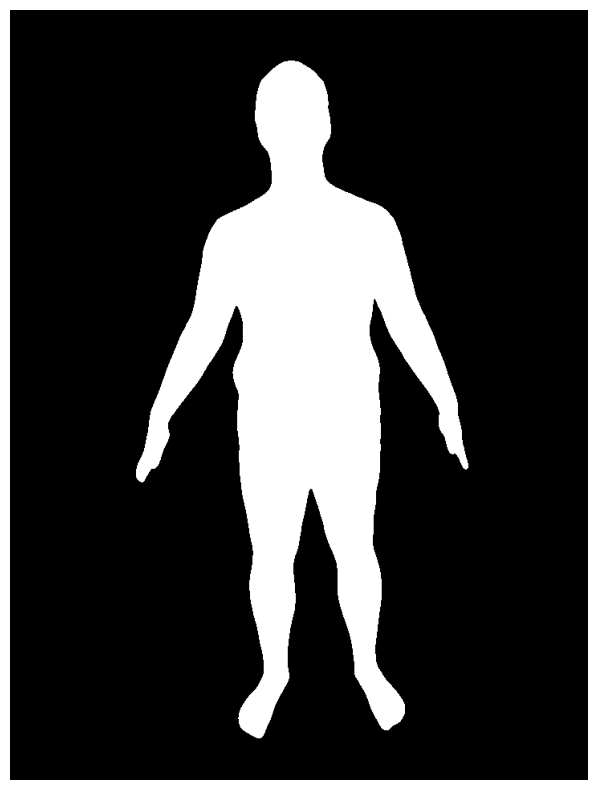

In [58]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(img_mpl)
ax.axis('off')
plt.show()

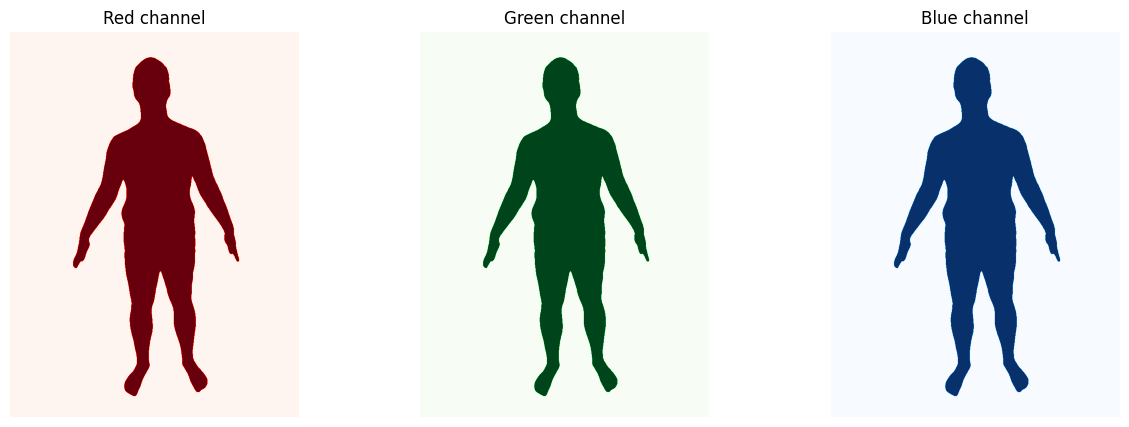

In [59]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(img_mpl[:,:,0], cmap='Reds')
axs[0].axis('off')
axs[0].set_title('Red channel')
axs[1].imshow(img_mpl[:,:,1], cmap='Greens')
axs[1].axis('off')
axs[1].set_title('Green channel')
axs[2].imshow(img_mpl[:,:,2], cmap='Blues')
axs[2].axis('off')
axs[2].set_title('Blue channel')
plt.show()


- Each PNG image is a complete RGB image.
- Each image has been captured and 3D-scanned in a lab by technicians

# Loading target features

In [61]:
hwg_metadata = pd.read_csv('train_data/hwg_metadata.csv')
measurements = pd.read_csv('train_data/measurements.csv')
subject_to_photo_map = pd.read_csv('train_data/subject_to_photo_map.csv')


In [12]:
hwg_metadata.head()

,subject_id,gender,height_cm,weight_kg
0,AhfyGaD1BKo0-u6PeQk2oI-Bw5l0XxpAqNroFuZuy0I,female,160.00,92.4
1,E8tDQ5IgdBwbjLIXu7GwcupEHYbi0eB18YNcsgsSbP8,female,175.75,102.8
2,59bc2767681516389ccf45f9,male,174.80,106.9
3,nRatvgqbYTN77typTgGm4bAurxzpvf5nYg2Mb3gdh8c,male,181.50,111.8
4,fkq68ww6bdyKT16FavI1x_G-u7YZ9SoT1GNMUTSJUek,female,161.60,93.0


In [13]:
hwg_metadata.shape

(2018, 4)

The `hwg_metadata` variable is a pandas DataFrame that contains information about individuals in a dataset. It has four columns: `subject_id`, `gender`, `height_cm`, and `weight_kg`. 

- The `subject_id` column represents a unique identifier for each individual.
- The `gender` column represents the gender of each individual.
- The `height_cm` column represents the height of each individual in centimeters.
- The `weight_kg` column represents the weight of each individual in kilograms.

The DataFrame has a total of 2018 entries, with each entry corresponding to a different individual. The data types of the columns are float64 for the height and weight columns, and object for the subject_id and gender columns. The DataFrame provides a summary of the data, including the number of non-null values and memory usage.


## Visualizing the metadata

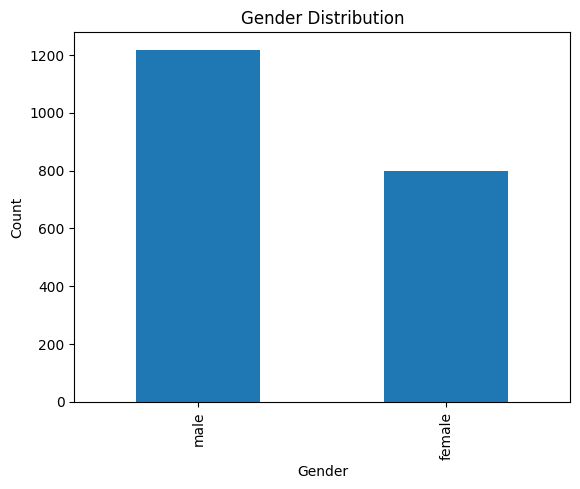

In [14]:
hwg_metadata['gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()


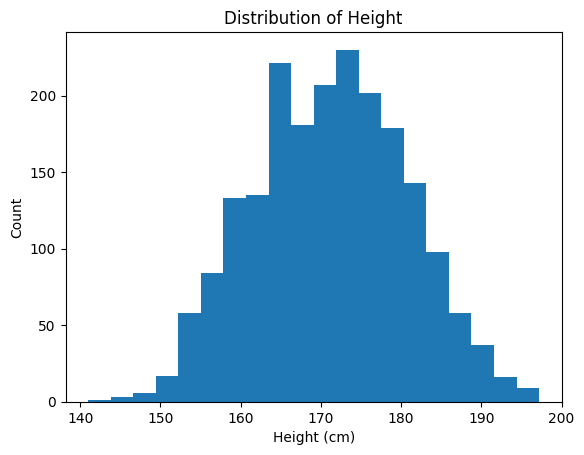

In [15]:
hwg_metadata['height_cm'].plot(kind='hist', bins=20)
plt.xlabel('Height (cm)')
plt.ylabel('Count')
plt.title('Distribution of Height')
plt.show()


## Target Feature Description

In [62]:
measurements.head()

,subject_id,ankle,arm-length,bicep,calf,chest,forearm,height,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist
0,-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg,24.343954,52.902378,33.294395,38.709511,102.526024,27.599094,177.610992,108.047134,81.736435,35.915691,67.891273,57.872795,92.286171,16.709131
1,-5OHO2b5mRDY1rvAf07sYYtekEEX7ViEGmvRr7l4tfc,22.001783,46.763233,28.288971,35.649963,99.253395,24.813375,164.379623,92.128685,75.127258,33.848778,60.541386,52.418320,87.307899,15.192038
2,-5iHTazqnmWBsnUY6ymoCw1kORMymRDaUla1eNOjgvI,26.565006,53.288597,30.800959,39.854950,102.391273,27.719795,183.718842,106.044121,84.055527,37.856457,72.004379,52.934086,96.596413,17.936598
3,-60o95b9oEE83BDV3GpsAVPA4TFvxuPPqtXEY5PApy8,24.779566,49.077751,34.613113,38.104267,111.164070,28.550409,169.059113,109.529465,74.310234,38.197800,68.536713,58.656673,103.395119,17.029860
4,-67TrwlJ3GSsqPeHaa2Nb0iQ-BKZfIx4ERysQPZ0-SY,20.788853,42.229557,24.527142,29.181356,93.627777,21.979038,146.516632,87.134102,67.269859,31.659197,52.697277,41.844944,74.400856,15.120061



The variable `measurements` is a pandas DataFrame that contains information about body measurements. It has 2018 rows and 15 columns.

The columns in the DataFrame are as follows:

1. `subject_id`: A unique identifier for each individual.
2. `ankle`: Measurement of the ankle circumference.
3. `arm-length`: Measurement of the length of the arm.
4. `bicep`: Measurement of the bicep circumference.
5. `calf`: Measurement of the calf circumference.
6. `chest`: Measurement of the chest circumference.
7. `forearm`: Measurement of the forearm circumference.
8. `height`: Measurement of the height in centimeters.
9. `hip`: Measurement of the hip circumference.
10. `leg-length`: Measurement of the length of the leg.
11. `shoulder-breadth`: Measurement of the breadth of the shoulders.
12. `shoulder-to-crotch`: Measurement from the shoulder to the crotch.
13. `thigh`: Measurement of the thigh circumference.
14. `waist`: Measurement of the waist circumference.
15. `wrist`: Measurement of the wrist circumference.

The data in the DataFrame is a combination of numerical and categorical values. The numerical values represent measurements in centimeters or circumference, while the categorical values represent the subject's unique identifier.

This DataFrame provides valuable information about body measurements, which can be used for various purposes such as clothing sizing, health assessment, and body composition analysis.


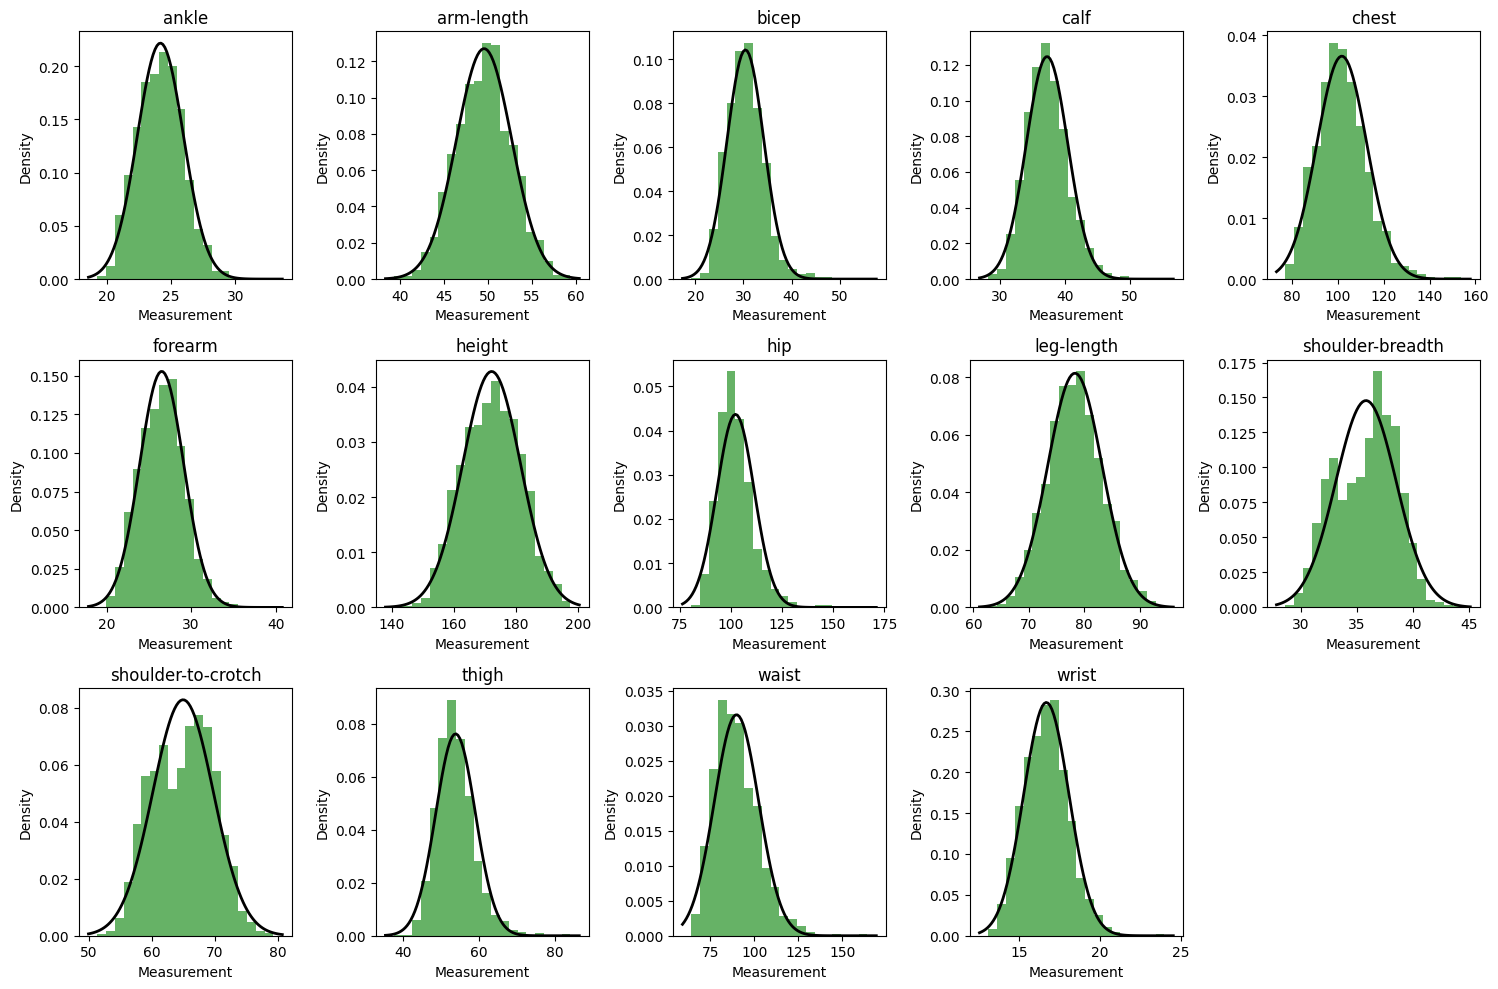

In [ ]:

# Define the columns to plot
columns = ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'height', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']

# Create a 3-row grid for the subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Plot normal distribution curve for each column in a separate subplot
for i, column in enumerate(columns):
    # Fit a normal distribution to the data
    mu, std = norm.fit(measurements[column])
    
    # Plot histogram
    axs[i].hist(measurements[column], bins=20, density=True, alpha=0.6, color='g')
    
    # Plot normal distribution curve
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axs[i].plot(x, p, 'k', linewidth=2)
    
    axs[i].set_title(column)
    axs[i].set_xlabel('Measurement')
    axs[i].set_ylabel('Density')

# Remove any empty subplots
if len(columns) < len(axs):
    for j in range(len(columns), len(axs)):
        fig.delaxes(axs[j])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


The distribution curves above give us an idea that the input images are randomly sampled, and not biased in any way

# Loading dataset functions

To load the data, we can define functions for it to make Model training easier later on

In [68]:
def load_csv(filepath):
    data = []
    with open(filepath, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)
        for row in reader:
            data.append(row)
    return header, data

def load_image(image_folder, photo_id):
    image_path = os.path.join(image_folder, f"{photo_id}.png")
    if os.path.exists(image_path):
        image = Image.open(image_path)
        return image
    else:
        return None


measurements_csv = "train_data/measurements.csv"
photo_map_csv = "train_data/subject_to_photo_map.csv"
image_folder = "train_images"



- The `load_csv` function takes a filepath as input and reads a CSV file using the `csv.reader` module. It initializes an empty list called `data` and iterates over each row in the CSV file, appending each row to the `data` list. The function returns the header (the first row of the CSV file) and the data (all subsequent rows) as a tuple.

- The `load_image` function takes an image folder path and a photo ID as input. It constructs the image path by joining the image folder path with the photo ID and the file extension ".png". If the image file exists at the specified path, it opens the image using the `Image.open` function from the PIL library and returns the image object. If the image file does not exist, it returns `None`.

- The code also defines three variables: `measurements_csv`, `photo_map_csv`, and `image_folder`, which store the file paths for the measurements CSV file, the subject-to-photo map CSV file, and the image folder, respectively.


# Designing and training our CNN

The CNN designed below will take the processed images as input and give all 14 measurements as its prediction. 

In [69]:
_, measurements_data = load_csv(measurements_csv)
_, photo_map_data = load_csv(photo_map_csv)

# Create dataset
data = []
targets = []
for subject_id, photo_id in photo_map_data:
    measurements = None
    for row in measurements_data:
        if row[0] == subject_id:
            measurements = [float(x) for x in row[1:]]
            break
    if measurements:
        image = load_image(image_folder, photo_id)
        if image is not None:
            data.append(image)
            targets.append(measurements)

data = np.array(data)
targets = np.array(targets)

# Split dataset into training and validation sets
train_data, val_data, train_targets, val_targets = train_test_split(data, targets, test_size=0.1, random_state=42)


# Define CNN model
model_input = layers.Input(shape=train_data[0].shape)
x = layers.Conv2D(32, (3, 3), activation='relu')(model_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
model_output = layers.Dense(train_targets.shape[1])(x)

model = Model(model_input, model_output)

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Train the model
history = model.fit(train_data, train_targets, epochs=10, batch_size=8, validation_data=(val_data, val_targets))

# Print MSE at each epoch
for epoch, mse in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1} - Validation MSE: {mse}")



Epoch 1/10

10/10 [==============================] - 29s 3s/step - loss: 35111488.0000 - val_loss: 6753.4399
Epoch 2/10
10/10 [==============================] - 25s 3s/step - loss: 5766.7217 - val_loss: 6077.0874
Epoch 3/10
10/10 [==============================] - 25s 3s/step - loss: 5829.2964 - val_loss: 6076.5112
Epoch 4/10
10/10 [==============================] - 25s 3s/step - loss: 5828.6494 - val_loss: 6075.7861
Epoch 5/10
10/10 [==============================] - 26s 3s/step - loss: 5827.8931 - val_loss: 6074.9482
Epoch 6/10
10/10 [==============================] - 25s 3s/step - loss: 5827.0112 - val_loss: 6073.9771
Epoch 7/10
10/10 [==============================] - 25s 3s/step - loss: 5825.9819 - val_loss: 6072.8291
Epoch 8/10
10/10 [==============================] - 25s 3s/step - loss: 5824.7681 - val_loss: 6071.4595
Epoch 9/10
10/10 [==============================] - 25s 3s/step - loss: 5823.3228 - val_loss: 6069.8408
Epoch 10/10
10/10 [==============================] - 25s 2

## Explanation of Model Architecture

1. Loading the CSV files:
   - The code starts by loading two CSV files: `measurements_csv` and `photo_map_csv`.
   - The `load_csv` function is used to load the data from these files.
   - The returned data is assigned to variables `measurements_data` and `photo_map_data`.

2. Creating the dataset:
   - Two empty lists, `data` and `targets`, are created to store the image data and corresponding measurements, respectively.
   - A loop is used to iterate over each `subject_id` and `photo_id` pair in `photo_map_data`.
   - Inside the loop, another loop is used to find the measurements corresponding to the current `subject_id` in `measurements_data`.
   - If measurements are found, the image corresponding to the `photo_id` is loaded using the `load_image` function.
   - If the image is not None, it is appended to the `data` list, and the measurements are appended to the `targets` list.
   - Finally, the `data` and `targets` lists are converted to numpy arrays.

3. Splitting the dataset:
   - The `train_test_split` function from scikit-learn is used to split the dataset into training and validation sets.
   - The `data` and `targets` arrays are split into `train_data`, `val_data`, `train_targets`, and `val_targets`.
   - The test size is set to 0.1, meaning 10% of the data will be used for validation.
   - The random state is set to 42 for reproducibility.

4. Defining the CNN model:
   - The model is defined using the Keras functional API.
   - The input shape of the model is the shape of a single image in the `train_data` array.
   - The model consists of three convolutional layers with 32, 64, and 64 filters, respectively.
   - Each convolutional layer is followed by a max pooling layer.
   - The output of the last convolutional layer is flattened and passed through a dense layer with 64 units and ReLU activation.
   - The final output layer has the same number of units as the number of measurements in the `train_targets` array.

5. Compiling the model:
   - The model is compiled using the Adam optimizer and mean squared error (MSE) loss function.
   - The optimizer is responsible for updating the model's weights during training.
   - The MSE loss function measures the mean squared difference between the predicted and actual measurements.

6. Training the model:
   - The `fit` method is called on the model to train it on the training data.
   - The `train_data` and `train_targets` arrays are used as input for training.
   - The number of epochs is set to 10, and the batch size is set to 8.
   - The validation data is specified using the `val_data` and `val_targets` arrays.

7. Printing the MSE at each epoch:
   - After training, a loop is used to iterate over each epoch and the corresponding MSE value from the validation data.
   - The MSE values are accessed from the `history` object returned by the `fit` method.
   - The epoch number is printed along with the validation MSE.


- The MSE for the initial model is too high at 6067, and thus, we can start optimizing and fine-tuning our model. 

- The following techniques aim to improve the performance of our model:

# Compressing image input

The first method employed is to compress the image shape as shown below:

In [74]:

#Reloading the data
_, measurements_data = load_csv(measurements_csv)
_, photo_map_data = load_csv(photo_map_csv)

data = []
targets = []
for subject_id, photo_id in photo_map_data:
    measurements = None
    for row in measurements_data:
        if row[0] == subject_id:
            measurements = [float(x) for x in row[1:]]
            break
    if measurements:
        image = load_image(image_folder, photo_id)
        if image is not None:
            # Resize image to smaller size
            image = tf.image.resize(image, (500, 500))
            data.append(image)
            targets.append(measurements)

data = np.array(data)
targets = np.array(targets)

# Split dataset into training and validation sets
train_data, val_data, train_targets, val_targets = train_test_split(data, targets, test_size=0.1, random_state=42)


# Define CNN model
model_input = layers.Input(shape=train_data[0].shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
model_output = layers.Dense(train_targets.shape[1])(x)

model = Model(model_input, model_output)

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Train the model
history = model.fit(train_data, train_targets, epochs=10, batch_size=8, validation_data=(val_data, val_targets))

# Print MSE at each epoch
for epoch, mse in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1} - Validation MSE: {mse}")


Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 4258279.5000 - val_loss: 4079.3030
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 2298.4458 - val_loss: 1185.2267
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 728.3721 - val_loss: 447.7719
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 223.4959 - val_loss: 135.0652
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 121.9884 - val_loss: 116.7914
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 86.3769 - val_loss: 95.0615
Epoch 7/10
10/10 [==============================] - 11s 1s/step - loss: 64.8072 - val_loss: 96.2032
Epoch 8/10
10/10 [==============================] - 11s 1s/step - loss: 59.6532 - val_loss: 86.1939
Epoch 9/10
10/10 [==============================] - 11s 1s/step - loss: 51.9897 - val_loss: 91.5728
Epoch 10/10
10/10 [==============================] - 11s 1s/step - loss: 47.2428 - 

- By simply reducing the image shape to 500x500, we have been able to reduce our Validation MSE by a substantial amount
- The model is now appearing to be viable with a low MSE

# Increased Model Complexity

After image compression, we will now add some more layers to our CNN to allow for more processing of inputs

In [76]:

_, measurements_data = load_csv(measurements_csv)
_, photo_map_data = load_csv(photo_map_csv)

# Create dataset
data = []
targets = []
for subject_id, photo_id in photo_map_data:
    measurements = None
    for row in measurements_data:
        if row[0] == subject_id:
            measurements = [float(x) for x in row[1:]]
            break
    if measurements:
        image = load_image(image_folder, photo_id)
        if image is not None:
            # Resize image to smaller size
            image = tf.image.resize(image, (128, 128))
            data.append(image)
            targets.append(measurements)

data = np.array(data)
targets = np.array(targets)

# Split dataset into training and validation sets
train_data, val_data, train_targets, val_targets = train_test_split(data, targets, test_size=0.1, random_state=42)

# Define CNN model
model_input = layers.Input(shape=train_data[0].shape)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(model_input)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(256, activation='relu')(x)
model_output = layers.Dense(train_targets.shape[1])(x)

model = Model(model_input, model_output)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_data, train_targets, epochs=15, batch_size=32, validation_data=(val_data, val_targets))

# Print MSE at each epoch
for epoch, mse in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1} - Validation MSE: {mse}")


Epoch 1/15
3/3 [==============================] - 10s 2s/step - loss: 177206.9219 - val_loss: 5090.9595
Epoch 2/15
3/3 [==============================] - 22s 10s/step - loss: 3442.4070 - val_loss: 581.2047
Epoch 3/15
3/3 [==============================] - 45s 15s/step - loss: 1538.8220 - val_loss: 916.2018
Epoch 4/15
3/3 [==============================] - 46s 12s/step - loss: 1334.8914 - val_loss: 240.1556
Epoch 5/15
3/3 [==============================] - 50s 16s/step - loss: 921.7684 - val_loss: 494.5398
Epoch 6/15
3/3 [==============================] - 60s 21s/step - loss: 850.8320 - val_loss: 159.6926
Epoch 7/15
3/3 [==============================] - 38s 10s/step - loss: 676.8910 - val_loss: 456.5126
Epoch 8/15
3/3 [==============================] - 42s 12s/step - loss: 599.2628 - val_loss: 159.3174
Epoch 9/15
3/3 [==============================] - 45s 16s/step - loss: 526.4291 - val_loss: 317.2942
Epoch 10/15
3/3 [==============================] - 49s 16s/step - loss: 456.3699 - va

Increasing the model complexity has not allowed us to make the Validation MSE lower, and thus we can conclude the initial model was complex enough to solve the problem, and additional layers are unnecessary

# Hyperparameter tuning:

Altering the dropout rate and learning rate may help find us our best model

In [77]:

_, measurements_data = load_csv(measurements_csv)
_, photo_map_data = load_csv(photo_map_csv)

# Create dataset
data = []
targets = []
for subject_id, photo_id in photo_map_data:
    measurements = None
    for row in measurements_data:
        if row[0] == subject_id:
            measurements = [float(x) for x in row[1:]]
            break
    if measurements:
        image = load_image(image_folder, photo_id)
        if image is not None:
            # Resize image to smaller size
            image = tf.image.resize(image, (128, 128))
            data.append(image)
            targets.append(measurements)

data = np.array(data)
targets = np.array(targets)

# Split dataset into training and validation sets
train_data, val_data, train_targets, val_targets = train_test_split(data, targets, test_size=0.1, random_state=42)

# Define function to create model
def create_model(dropout_rate):
    model_input = layers.Input(shape=train_data[0].shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(model_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Dropout rate as a hyperparameter
    x = layers.Dense(256, activation='relu')(x)
    model_output = layers.Dense(train_targets.shape[1])(x)
    model = Model(model_input, model_output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Perform grid search for dropout rate
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]  # Different dropout rates to try

results = []  # To store results of each dropout rate

for dropout_rate in dropout_rates:
    print(f"Training model with dropout rate: {dropout_rate}")
    model = create_model(dropout_rate)
    history = model.fit(train_data, train_targets, epochs=15, batch_size=32, validation_data=(val_data, val_targets), verbose=0)
    val_loss = history.history['val_loss'][-1]  # Get the final validation loss
    results.append((dropout_rate, val_loss))

# Print MSE for each dropout rate
for dropout_rate, val_loss in results:
    print(f"Dropout Rate: {dropout_rate}, Final Validation MSE: {val_loss}")


Training model with dropout rate: 0.1
Training model with dropout rate: 0.2
Training model with dropout rate: 0.3
Training model with dropout rate: 0.4
Training model with dropout rate: 0.5
Dropout Rate: 0.1, Final Validation MSE: 129.0513916015625
Dropout Rate: 0.2, Final Validation MSE: 138.69113159179688
Dropout Rate: 0.3, Final Validation MSE: 97.1863784790039
Dropout Rate: 0.4, Final Validation MSE: 140.40660095214844
Dropout Rate: 0.5, Final Validation MSE: 144.77415466308594


From dropout rate analysis, a rate of 0.3 would produce the lowest MSE

# Changing Activation Functions and Learning Rates

Now we will vary the activation function and learning rate and test the performance of our model

In [78]:
_, measurements_data = load_csv(measurements_csv)
_, photo_map_data = load_csv(photo_map_csv)

# Create dataset
data = []
targets = []
for subject_id, photo_id in photo_map_data:
    measurements = None
    for row in measurements_data:
        if row[0] == subject_id:
            measurements = [float(x) for x in row[1:]]
            break
    if measurements:
        image = load_image(image_folder, photo_id)
        if image is not None:
            # Resize image to smaller size
            image = tf.image.resize(image, (128, 128))
            data.append(image)
            targets.append(measurements)

data = np.array(data)
targets = np.array(targets)

# Split dataset into training and validation sets
train_data, val_data, train_targets, val_targets = train_test_split(data, targets, test_size=0.1, random_state=42)

# Define hyperparameters to try
activation_functions = ['relu', 'sigmoid', 'tanh']
learning_rates = [0.001, 0.0001, 0.00001]

best_model = None
best_mse = float('inf')

# Try different activation functions and learning rates
for activation_func in activation_functions:
    for learning_rate in learning_rates:
        # Define CNN model
        model_input = layers.Input(shape=train_data[0].shape)
        x = layers.Conv2D(32, (3, 3), activation=activation_func, padding='same')(model_input)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation=activation_func, padding='same')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(128, (3, 3), activation=activation_func, padding='same')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation=activation_func)(x)
        model_output = layers.Dense(train_targets.shape[1])(x)

        model = Model(model_input, model_output)

        # Compile the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')

        # Train the model
        history = model.fit(train_data, train_targets, epochs=10, batch_size=8, validation_data=(val_data, val_targets), verbose=0)

        # Get the final MSE
        final_mse = history.history['val_loss'][-1]
        print(f"Activation Function: {activation_func}, Learning Rate: {learning_rate}, Final Validation MSE: {final_mse}")

        # Check if this model has the lowest MSE so far
        if final_mse < best_mse:
            best_mse = final_mse
            best_model = model

print(f"Best Model: {best_model}, Validation MSE: {best_mse}")


Activation Function: relu, Learning Rate: 0.001, Final Validation MSE: 99.19473266601562
Activation Function: relu, Learning Rate: 0.0001, Final Validation MSE: 62.19618225097656
Activation Function: relu, Learning Rate: 1e-05, Final Validation MSE: 119.23020935058594
Activation Function: sigmoid, Learning Rate: 0.001, Final Validation MSE: 4999.626953125
Activation Function: sigmoid, Learning Rate: 0.0001, Final Validation MSE: 5793.20166015625
Activation Function: sigmoid, Learning Rate: 1e-05, Final Validation MSE: 5799.02734375
Activation Function: tanh, Learning Rate: 0.001, Final Validation MSE: 4212.904296875
Activation Function: tanh, Learning Rate: 0.0001, Final Validation MSE: 5391.216796875
Activation Function: tanh, Learning Rate: 1e-05, Final Validation MSE: 5506.04833984375
Best Model: <keras.src.engine.functional.Functional object at 0x00000241470A8E50>, Validation MSE: 62.19618225097656


### Analysis

- **relu Activation Function:**
    - For a learning rate of 0.001, the model achieved a final validation MSE of 99.1947.
    - A lower MSE of 62.1962 was attained with a learning rate of 0.0001, indicating improved performance compared to the higher learning rate.
    - However, using a learning rate of 1e-05 resulted in a higher MSE of 119.2302, suggesting that the learning rate might be too low for optimal performance.

- **sigmoid Activation Function:**
    - Models with the sigmoid activation function generally performed poorly across all learning rates. Even with the lowest learning rate of 1e-05, the MSE remained high, with values exceeding 5000.
    - This indicates that the sigmoid activation function might not be suitable for the given task or dataset.

- **tanh Activation Function:**
    - The tanh activation function yielded varying results based on the learning rate. While a learning rate of 0.001 led to an MSE of 4212.9043, which is lower than sigmoid, it was still higher than relu.
    - Similarly, models with learning rates of 0.0001 and 1e-05 resulted in MSE values of 5391.2168 and 5506.0483, respectively.

### Conclusion
- Among the activation functions tested, the relu activation function with a learning rate of 0.0001 demonstrated the best performance, achieving the lowest MSE of 62.1962 on the validation set.
- Thus, we will take this particular model as our final model, and train it


# Finalized Model Training

- Our final model will be one with image compression incorporated, but to a lower degree.
- It will have the relu activation function with a learning rate of 0.0001.
- It will also have a simpler architecture since our initial model performed better than our complex model.
- We will increase the epochs to 50 to meet industry Computer Vision standards, and a better model fitting.
- We will change the batch size to 32.
- The final model code is given below:

In [79]:
_, measurements_data = load_csv(measurements_csv)
_, photo_map_data = load_csv(photo_map_csv)

# Create dataset
data = []
targets = []
for subject_id, photo_id in photo_map_data:
    measurements = None
    for row in measurements_data:
        if row[0] == subject_id:
            measurements = [float(x) for x in row[1:]]
            break
    if measurements:
        image = load_image(image_folder, photo_id)
        if image is not None:
            # Resize image to smaller size
            image = tf.image.resize(image, (128, 128))
            data.append(image)
            targets.append(measurements)

data = np.array(data)
targets = np.array(targets)

# Split dataset into training and validation sets
train_data, val_data, train_targets, val_targets = train_test_split(data, targets, test_size=0.1, random_state=42)


# Define CNN model
model_input = layers.Input(shape=train_data[0].shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
model_output = layers.Dense(train_targets.shape[1])(x)

model = Model(model_input, model_output)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(train_data, train_targets, epochs=50, batch_size=32, validation_data=(val_data, val_targets))

# Print MSE at each epoch
for epoch, mse in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1} - Validation MSE: {mse}")


Epoch 1/50
3/3 [==============================] - 2s 222ms/step - loss: 3306.7192 - val_loss: 1283.0116
Epoch 2/50
3/3 [==============================] - 0s 139ms/step - loss: 936.1346 - val_loss: 380.7338
Epoch 3/50
3/3 [==============================] - 0s 140ms/step - loss: 316.6540 - val_loss: 338.9430
Epoch 4/50
3/3 [==============================] - 0s 142ms/step - loss: 284.9839 - val_loss: 349.7895
Epoch 5/50
3/3 [==============================] - 0s 139ms/step - loss: 242.4796 - val_loss: 230.7906
Epoch 6/50
3/3 [==============================] - 0s 138ms/step - loss: 169.1477 - val_loss: 177.2896
Epoch 7/50
3/3 [==============================] - 0s 135ms/step - loss: 133.0326 - val_loss: 118.1319
Epoch 8/50
3/3 [==============================] - 0s 136ms/step - loss: 87.5243 - val_loss: 128.4425
Epoch 9/50
3/3 [==============================] - 0s 136ms/step - loss: 89.1748 - val_loss: 145.0096
Epoch 10/50
3/3 [==============================] - 0s 137ms/step - loss: 83.8191 -

Thus, our final model trained has a presentable and satisfactory mean squared error of 36.3.

## Saving the model

In [80]:
model.save('final_model.h5')

c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing the model

- After extensive training and model optimization, we will test our model on test data that we have fetched from the same repository

In [82]:
# Load the test data
_, test_measurements_data = load_csv("test_data/measurements.csv")
_, test_photo_map_data = load_csv("test_data/subject_to_photo_map.csv")

# Create dataset
test_data = []
test_targets = []
for subject_id, photo_id in test_photo_map_data:
    measurements = None
    for row in test_measurements_data:
        if row[0] == subject_id:
            measurements = [float(x) for x in row[1:]]
            break
    if measurements:
        image = load_image(image_folder, photo_id)
        if image is not None:
            # Resize image to smaller size
            image = tf.image.resize(image, (128, 128))
            test_data.append(image)
            test_targets.append(measurements)

# Convert lists to numpy arrays
test_data = np.array(test_data)
test_targets = np.array(test_targets)

# Load the trained model
model = load_model("final_model.h5")

# Perform predictions
predictions = model.predict(test_data)

# Calculate relative error
average_accuracy = 0
for i in (range(len(predictions))):
  relative_error = 1 - (abs(predictions[i] - test_targets[i]) / test_targets[i])
  print("Accuracy of each prediction:", round(sum(relative_error)/len(relative_error),2))
  average_accuracy += sum(relative_error)/len(relative_error)

print("Average Accuracy:", round((average_accuracy/len(predictions))*100),"%")




1/1 [==============================] - 0s 141ms/step
Accuracy of each prediction: 0.96
Accuracy of each prediction: 0.92
Accuracy of each prediction: 0.76
Accuracy of each prediction: 0.88
Accuracy of each prediction: 0.93
Accuracy of each prediction: 0.88
Accuracy of each prediction: 0.92
Accuracy of each prediction: 0.95
Accuracy of each prediction: 0.9
Accuracy of each prediction: 0.91
Accuracy of each prediction: 0.94
Accuracy of each prediction: 0.86
Accuracy of each prediction: 0.91
Accuracy of each prediction: 0.94
Accuracy of each prediction: 0.85
Average Accuracy: 90 %


## Analysis of test results:

- The testing is done on 15 test subjects i.e. 15 unique subject_id(s)
- The number of test images as input is 24.
- This implies that one test subject can have multiple (different) test images attributed to it.
- The average accuracy achieved by our model is 90%
- This shows the model is optimized for unknown inputs, and is not overfitted on our training data

# Key Findings and Conclusion

- *Model Optimization*: Through iterative optimization steps, including image compression, adjusting model complexity, and hyperparameter tuning, the project achieves a significant reduction in MSE, indicating improved model performance.

- *Impact of Hyperparameters*: Hyperparameters such as dropout rates, learning rates, and activation functions play a crucial role in model performance. Fine-tuning these parameters leads to enhanced predictive accuracy.

- *Generalization and Robustness*: The finalized model demonstrates robustness and generalization capability, performing well on unseen test data. This ensures its practical applicability across diverse scenarios and individuals.

- *Practical Implications*: The developed Human Body Measurement Predictor holds significant potential for various industries, including fashion, healthcare, and fitness, facilitating automated anthropometric analysis and personalized services.

## Future Improvements

- *Enhanced Dataset*: Continual improvement and expansion of the dataset can further enhance model accuracy and robustness.

- *Advanced Techniques*: Integration of advanced computer vision techniques, such as pose estimation and 3D reconstruction, can enrich measurement extraction and modeling.

- *Real-time Applications*: Deployment of the model in real-time applications, such as virtual fitting rooms or health monitoring systems, can unlock broader practical applications.

- *User Interface and Accessibility*: Developing user-friendly interfaces and accessible tools can democratize access to body measurement prediction technology, catering to a broader user base.

In summary, the Human Body Measurement Predictor project showcases the power of computer vision and machine learning in addressing complex challenges associated with human body measurement extraction. Through systematic analysis, iterative refinement, and rigorous evaluation, the project delivers a robust and scalable solution with far-reaching implications across diverse industries and applications.

## Made by Muhammad Bilal

[My github](https://github.com/mbilal234)